## Imports

In [2]:
import pandas as pd
import numpy as np
import re

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import numpy as np
np.random.seed(2018)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from transformers import BertTokenizer, BertModel, BertForMaskedLM, PreTrainedModel
from keras.preprocessing.sequence import pad_sequences
import torch

import sklearn
import sklearn.cluster
import sklearn.decomposition
import sklearn.ensemble
import sklearn.manifold
import sklearn.multiclass
import sklearn.tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

## Data Input

In [3]:
# reading iteratively input files
input_df = pd.read_csv('BBCArticles.csv')
display(input_df.sample(5))
display(input_df['Category'].value_counts())

,ArticleId,Text,Category
427,930,casual gaming to take off games aimed at ca...,tech
60,464,dozens held over id fraud site twenty-eight pe...,tech
283,533,england s defensive crisis grows england s def...,sport
841,174,commons hunt protest charges eight protesters ...,politics
913,1792,choose hope over fear - kennedy voters will ha...,politics


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

## Data Preprocessing

Steps:
1. Cutting docs to words
2. Removing stop-words
3. Lemmatization of words


In [4]:
#factorising categories
input_df['Category ID'] = pd.factorize(input_df['Category'])[0]
print(pd.factorize(input_df['Category']))
CatID = []
for i in range(len(input_df)):
    if input_df['Category'][i] == 'business':
        CatID.append(0)
    elif input_df['Category'][i] == 'tech':
        CatID.append(1)
    elif input_df['Category'][i] == 'politics':
        CatID.append(2)
    elif input_df['Category'][i] == 'sport':
        CatID.append(3)
    elif input_df['Category'][i] == 'entertainment':
        CatID.append(4)
input_df['Category ID'] = CatID

(array([0, 0, 0, ..., 0, 1, 1], dtype=int64), Index(['business', 'tech', 'politics', 'sport', 'entertainment'], dtype='object'))


In [5]:
# splitting and cleaning text
splitted_texts = [doc.split() for doc in input_df['Text']]
input_df['Splitted Text'] = splitted_texts
stripped = []
for i in range(len(input_df['Splitted Text'])):
    strip = [word.strip(' .,)(""-\'') for word in input_df['Splitted Text'][i]]
    stripped.append(strip)
input_df['Stripped Text'] = stripped
input_df.head(5)

,ArticleId,Text,Category,Category ID,Splitted Text,Stripped Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0,"[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers..."
1,154,german business confidence slides german busin...,business,0,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,0,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,1,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,0,"[enron, bosses, in, $168m, payout, eighteen, f...","[enron, bosses, in, $168m, payout, eighteen, f..."


In [6]:
# removing stop words
filtered = []
stop_words = set(stopwords.words('english'))
for i in range(len(input_df['Stripped Text'])):
    filtered_sentence = [w for w in input_df['Stripped Text'][i] if not w in stop_words]
    filtered.append(filtered_sentence)
input_df['Filtered Text'] = filtered

In [7]:
input_df

,ArticleId,Text,Category,Category ID,Splitted Text,Stripped Text,Filtered Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0,"[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers..."
1,154,german business confidence slides german busin...,business,0,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,0,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,1,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,0,"[enron, bosses, in, $168m, payout, eighteen, f...","[enron, bosses, in, $168m, payout, eighteen, f...","[enron, bosses, $168m, payout, eighteen, forme..."
5,1582,howard truanted to play snooker conservative...,politics,2,"[howard, truanted, to, play, snooker, conserva...","[howard, truanted, to, play, snooker, conserva...","[howard, truanted, play, snooker, conservative..."
6,651,wales silent on grand slam talk rhys williams ...,sport,3,"[wales, silent, on, grand, slam, talk, rhys, w...","[wales, silent, on, grand, slam, talk, rhys, w...","[wales, silent, grand, slam, talk, rhys, willi..."
7,1797,french honour for director parker british film...,entertainment,4,"[french, honour, for, director, parker, britis...","[french, honour, for, director, parker, britis...","[french, honour, director, parker, british, fi..."
8,2034,car giant hit by mercedes slump a slump in pro...,business,0,"[car, giant, hit, by, mercedes, slump, a, slum...","[car, giant, hit, by, mercedes, slump, a, slum...","[car, giant, hit, mercedes, slump, slump, prof..."
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4,"[fockers, fuel, festive, film, chart, comedy, ...","[fockers, fuel, festive, film, chart, comedy, ...","[fockers, fuel, festive, film, chart, comedy, ..."


## Lemmatization

In [8]:
lemmatizer = WordNetLemmatizer() 
#docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
lemmatized = []
for i in range(len(input_df['Filtered Text'])):
    lemat = [lemmatizer.lemmatize(w) for w in input_df['Filtered Text'][i] ]
    lemmatized.append(filtered_sentence)
input_df['Lemmatized Text'] = filtered
  

# Vector representations

Methods to compare:
- Bert
- Fasttext
- Word2Vec
- LDA

## 1. LDA

In [9]:
dictionary = Dictionary(input_df['Lemmatized Text'])
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

test_data = [dictionary.doc2bow(text) for text in input_df['Lemmatized Text'][1191:]]

In [42]:
len(input_df)

1490

In [10]:
#getting representative train/test split

test = input_df[input_df['Category ID']==0][:50][['ArticleId','Category ID','Lemmatized Text']].copy()
test = test.append(input_df[input_df['Category ID']==1][:50][['ArticleId','Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==2][:50][['ArticleId','Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==3][:50][['ArticleId','Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==4][:50][['ArticleId','Category ID','Lemmatized Text']].copy())
test = test.reset_index(drop=True)

train = input_df[input_df['Category ID']==0][51:][['ArticleId','Category ID','Lemmatized Text']].copy()
train = train.append(input_df[input_df['Category ID']==1][51:][['ArticleId','Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==2][51:][['ArticleId','Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==3][51:][['ArticleId','Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==4][51:][['ArticleId','Category ID','Lemmatized Text']].copy())
train = train.reset_index(drop=True)

In [11]:





corpus = [dictionary.doc2bow(text) for text in train['Lemmatized Text']]
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# Set training parameters.
num_topics = 5
chunksize = 2000

eval_every = None  # Don't evaluate model perplexity, takes too much time.



In [39]:
# import logging
# logging.basicConfig( level=logging.INFO)
Scores = []
passes = 20
iterations = 300
for i in range(1):
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=1
    )

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=input_df['Lemmatized Text'], dictionary=dictionary, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)



Coherence Score:  -1.4985180289063689


0 -biz

1- tech

2- polit

3 - sport

4 - enterta

In [40]:
model.print_topics()

[(0,
  '0.021*"film" + 0.014*"best" + 0.009*"one" + 0.009*"year" + 0.008*"us" + 0.008*"show" + 0.007*"music" + 0.007*"awards" + 0.007*"new" + 0.007*"first"'),
 (1,
  '0.015*"us" + 0.012*"year" + 0.009*"market" + 0.007*"growth" + 0.006*"sales" + 0.006*"firm" + 0.006*"company" + 0.006*"new" + 0.006*"2004" + 0.006*"last"'),
 (2,
  '0.025*"mr" + 0.011*"government" + 0.009*"labour" + 0.007*"election" + 0.007*"people" + 0.007*"party" + 0.006*"blair" + 0.006*"could" + 0.006*"minister" + 0.005*"new"'),
 (3,
  '0.012*"game" + 0.009*"england" + 0.008*"first" + 0.007*"win" + 0.007*"world" + 0.006*"last" + 0.006*"two" + 0.006*"time" + 0.006*"one" + 0.006*"back"'),
 (4,
  '0.016*"people" + 0.008*"mr" + 0.007*"mobile" + 0.007*"new" + 0.007*"one" + 0.006*"could" + 0.006*"use" + 0.006*"software" + 0.006*"technology" + 0.006*"users"')]

In [43]:
# Testing accuracy
test_corpus = [dictionary.doc2bow(text) for text in test['Lemmatized Text']]
top_topic = []
for i in range(len(test)):
    lda = model.get_document_topics(test_corpus[i])
    topic_probab = [lis[1] for lis in lda]
    top_topic.append(lda[topic_probab.index(max(topic_probab))][0])
test['LDA Topic'] = top_topic
LDA_toCat = []
for i in range(len(test)):
    if test['LDA Topic'][i] == 0:
        LDA_toCat.append(4)
    elif test['LDA Topic'][i] == 1:
        LDA_toCat.append(0)
    elif test['LDA Topic'][i] == 2:
        LDA_toCat.append(2)
    elif test['LDA Topic'][i] == 3:
        LDA_toCat.append(3)
    elif test['LDA Topic'][i] == 4:
        LDA_toCat.append(1)
test['LDA to Cat ID'] = LDA_toCat
acc = (len(test[test['Category ID'] ==test['LDA to Cat ID']])/len(test))*100
print("Accuracy: ",acc," %")

Accuracy:  92.4  %


In [120]:
from gensim.test.utils import datapath
temp_file = datapath("model")
model.save(temp_file)
 # Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [100]:
model.print_topics()

[(0,
  '0.015*"people" + 0.007*"new" + 0.007*"mobile" + 0.007*"mr" + 0.007*"one" + 0.006*"could" + 0.006*"technology" + 0.006*"use" + 0.006*"software" + 0.006*"music"'),
 (1,
  '0.011*"game" + 0.009*"england" + 0.008*"first" + 0.007*"world" + 0.007*"win" + 0.006*"last" + 0.006*"two" + 0.006*"one" + 0.006*"time" + 0.006*"back"'),
 (2,
  '0.021*"film" + 0.014*"best" + 0.010*"year" + 0.009*"one" + 0.008*"us" + 0.008*"show" + 0.007*"awards" + 0.007*"new" + 0.007*"music" + 0.006*"first"'),
 (3,
  '0.025*"mr" + 0.010*"government" + 0.010*"labour" + 0.009*"people" + 0.008*"election" + 0.008*"party" + 0.007*"blair" + 0.006*"could" + 0.006*"minister" + 0.006*"new"'),
 (4,
  '0.015*"us" + 0.010*"year" + 0.008*"market" + 0.006*"growth" + 0.006*"company" + 0.006*"firm" + 0.006*"new" + 0.006*"mr" + 0.005*"economy" + 0.005*"government"')]

In [123]:
def diffGraph(mdiff, title="", annotation=None):
    
    

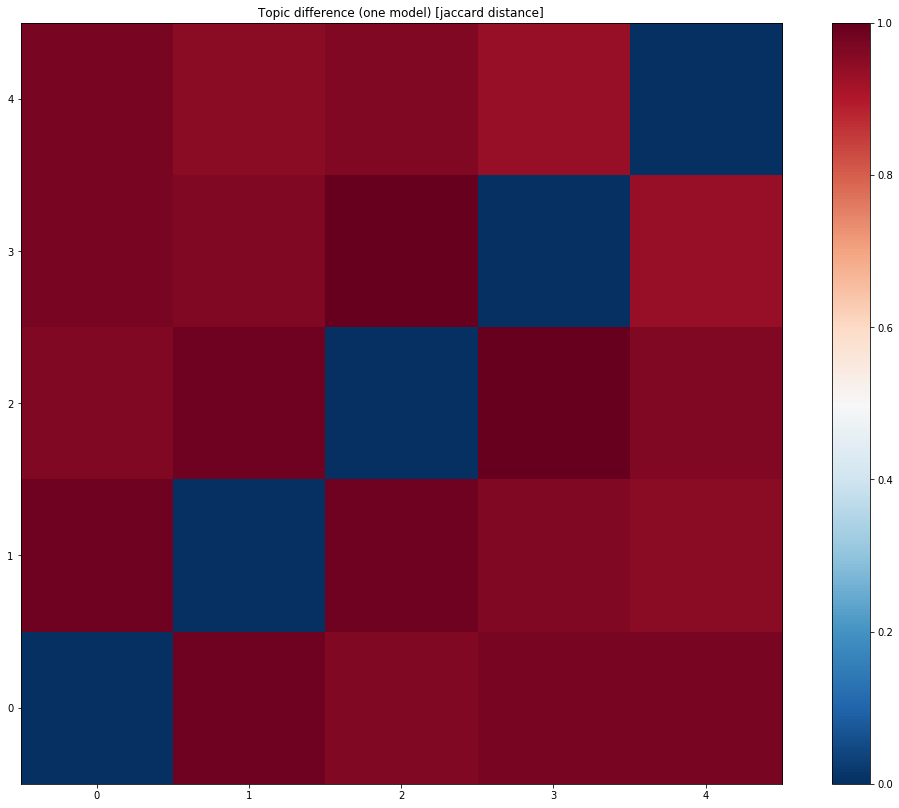

In [126]:
import matplotlib.pyplot as plt
mdiff, annotation = model.diff(model, distance='jaccard', num_words=50)
fig, ax = plt.subplots(figsize=(18, 14))
data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
plt.title("Topic difference (one model) [jaccard distance]")
plt.colorbar(data)
plt.savefig('LDA_topic_diff.png')

## 2. Doc2Vec

In [127]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_df['Lemmatized Text'])]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

In [128]:
input_df['vector'] = [model.docvecs[i] for i in range(len(input_df))]

In [129]:
a = np.zeros(shape=(len(input_df),100))
scatter_vector = pd.DataFrame(a)
for i in range(len(input_df)):
    for j in range(100):
        scatter_vector.at[i,j] = input_df['vector'][i][j]
input_df = pd.concat([input_df,scatter_vector],axis=1)
input_df.head(3)

,ArticleId,Text,Category,Category ID,Splitted Text,Stripped Text,Filtered Text,Lemmatized Text,vector,0,...,90,91,92,93,94,95,96,97,98,99
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0,"[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers...","[worldcom, ex-boss, launches, defence, lawyers...","[-0.15270351, -0.02197619, 0.4548754, -0.18382...",-0.152704,...,0.061465,0.100743,-0.004485,0.202469,0.444531,-0.259286,0.269641,-0.096439,0.317679,0.081872
1,154,german business confidence slides german busin...,business,0,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[-0.15099052, -0.038611285, 0.48841754, -0.206...",-0.150991,...,0.065327,0.119741,-0.012582,0.234982,0.495664,-0.281125,0.283338,-0.129187,0.315969,0.063930
2,1101,bbc poll indicates economic gloom citizens in ...,business,0,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...","[-0.18510136, -0.04813677, 0.61543113, -0.2420...",-0.185101,...,0.070489,0.148433,-0.024741,0.308090,0.612346,-0.362434,0.364767,-0.150098,0.410475,0.089512


## BERT

In [161]:
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

MAX_LEN = 128
# Tokenize input
tokenized_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in input_df['Lemmatized Text']]
# Padding input tokens
input_ids = pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")




attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

segments_tensors = torch.tensor(np.array(input_ids)).to(torch.int64)


model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.eval()

with torch.no_grad():
    outputs = model(segments_tensors)

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at C:\Users\JakubowskiL\.cache\torch\transformers\96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at C:\Users\JakubowskiL\.cache\torch\transformers\45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:transformers.configuration_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_siz

# Classifiers

In [163]:
output_avg = np.mean(outputs[0].numpy(),1)
X = output_avg
y = input_df['Category ID']

In [135]:
y = input_df['Category ID']
X = input_df.iloc[:,9:]

In [169]:
clf = MLPClassifier(random_state=1,
                            max_iter=200)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9503768960339898

In [166]:
clf = svm.LinearSVC()
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

C:\Users\JakubowskiL\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:9

0.9470278957168297

In [167]:
clf = GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4, max_depth= None, random_state= 2,
                   min_samples_split= 5)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9255550775255786